# Sentiment Analysis



The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.


**(a) ** We first read in the tweet data. Read the data present in `train.csv` file.

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [64]:
# your code here
import csv
sentiment_text=[]
sentiment=[]
train_dataset=[]

with open('./data/train.csv','r',encoding='iso8859') as csv_file:
    csv_reader=csv.reader(csv_file,delimiter=',')
    lineCount=0
    for row in csv_reader:
        
        if not(lineCount==0):
            #print(row)
            #text=row[len(row)-1]
            #print(text)
            train_dataset.append([int(row[0]),row[len(row)-1]])
            sentiment_text.append(row[len(row)-1])
            sentiment.append(int(row[0]))
            #print(row[len(row)-1])
        lineCount+=1

In [65]:
import numpy as np

print('Total Sentiments in dataset: ',len(sentiment))

sentiment=np.array(sentiment)
sentiment_text=np.array(sentiment_text)
negative_sentiment_count=np.count_nonzero(sentiment==0)
print('Negative Sentiment Labels Count',negative_sentiment_count)

positive_sentiment_count=np.count_nonzero(sentiment==1)
print('Positive Sentiment Labels Count',positive_sentiment_count)

Total Sentiments in dataset:  1599999
Negative Sentiment Labels Count 799999
Positive Sentiment Labels Count 800000


In [66]:
import random
import spacy
nlp = spacy.load('en_core_web_sm')

random_train_dataset=random.sample(train_dataset,30000)
#random_train_dataset=random.sample(train_dataset,10000)
random_train_dataset_text=np.array([data[1] for data in random_train_dataset])

random_train_dataset_labels=np.array([data[0] for data in random_train_dataset])


In [67]:
#for data in random_train_dataset:
pos_count=np.count_nonzero(random_train_dataset_labels==0)
neg_count=np.count_nonzero(random_train_dataset_labels==1)

print('Sample Dataset with Positive Sentiment Labels Count: ',pos_count)
print('Sample Dataset with Negative Sentiment Labels Count: ',neg_count)

Sample Dataset with Positive Sentiment Labels Count:  14991
Sample Dataset with Negative Sentiment Labels Count:  15009


**(b) ** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [68]:
import torch
import torch.nn as nn
from torchsummaryX import summary

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

In [69]:
# your code here
proper_train_size = int(len(random_train_dataset) * 0.8)
val_size = len(random_train_dataset) - proper_train_size

In [70]:
proper_train_dataset, val_dataset = torch.utils.data.random_split(random_train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])


In [71]:
from torchnlp.encoders.text import SpacyEncoder


In [72]:
encoder = SpacyEncoder([data[1] for data in proper_train_dataset])

In [73]:
proper_train_encoded=[encoder.encode(data[1]) for data in proper_train_dataset]

In [74]:
proper_train_labels = torch.tensor([data[0]
                                    for data in proper_train_dataset])

In [75]:
val_encoded = [encoder.encode(data[1]) for data in val_dataset]

In [76]:
val_labels = torch.tensor([data[0] for data in val_dataset])

In [77]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))


In [78]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [79]:
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [80]:
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

In [81]:
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 42768]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          4.319426M
Trainable params        42.626k
Non-trainable params    4.2768M
Mult-Adds               42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 42768]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


In [82]:
num_epochs = 10  # during optimization, how many times we look at training data

batch_size = 128  # during optimization, how many training data to use at each step
learning_rate = 0.05  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)



Epoch 1 [==================================================] 24000/24000
  Train accuracy: 0.7145
  Validation accuracy: 0.7073
Epoch 2 [==================================================] 24000/24000
  Train accuracy: 0.6990
  Validation accuracy: 0.6822
Epoch 3 [==================================================] 24000/24000
  Train accuracy: 0.7275
  Validation accuracy: 0.7107
Epoch 4 [==================================================] 24000/24000
  Train accuracy: 0.7277
  Validation accuracy: 0.7062
Epoch 5 [==================================================] 24000/24000
  Train accuracy: 0.7253
  Validation accuracy: 0.7025
Epoch 6 [==================================================] 24000/24000
  Train accuracy: 0.7382
  Validation accuracy: 0.7187
Epoch 7 [==================================================] 24000/24000
  Train accuracy: 0.7358
  Validation accuracy: 0.7107
Epoch 8 [==================================================] 24000/24000
  Train accuracy: 0.7217
  Vali

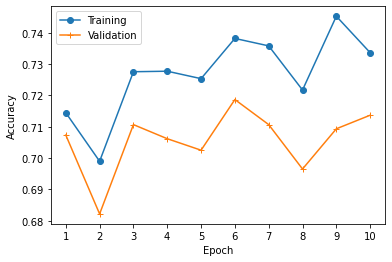

In [83]:
UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

LSTM Testing

In [84]:
import csv
test_sentiment_text=[]
test_sentiment=[]
test_dataset=[]

with open('./data/test.csv','r',encoding='iso8859') as csv_file:
    csv_reader=csv.reader(csv_file,delimiter=',')
    lineCount=0
    for row in csv_reader:
        
        if not(lineCount==0):
            #print(row)
            test_dataset.append([int(row[0]),row[len(row)-1]])
            test_sentiment_text.append(row[len(row)-1])
            test_sentiment.append(int(row[0]))
            #print(row[len(row)-1])
        lineCount+=1

In [85]:
test_encoded = [encoder.encode(data[1]) for data in test_dataset]

In [86]:
test_labels = torch.tensor([data[0] for data in test_dataset])

In [87]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

In [88]:
print('LSTM Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

LSTM Test accuracy: 0.5975855130784709


**(c) ** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [89]:

from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(max_df=0.95,
                                min_df=20,
                                stop_words='english')

tf=tf_vectorizer.fit_transform(random_train_dataset_text)
#tf_vectorizer.fit(random_train_dataset_text)
proper_train_dataset_text=np.array([data[1] for data in proper_train_dataset])
proper_train_labels=np.array([data[0] for data in proper_train_dataset])
proper_train_features=tf_vectorizer.transform(proper_train_dataset_text)

val_dataset_text=np.array([data[1] for data in val_dataset])
val_labels=np.array([data[0] for data in val_dataset])
val_features=tf_vectorizer.transform(val_dataset_text)                                   

tf=tf.toarray()

In [90]:
print(tf.shape)

(30000, 1411)
1411


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(tf.shape[1]) / 4)),
                                                int(np.ceil(np.sqrt(tf.shape[1]))),
                                                int(np.ceil(np.sqrt(tf.shape[1]))*4)]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]  # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_error = np.inf  # assumes that a lower error is better
for hyperparam_setting in hyperparameter_settings:
    # your code to train and score the training data here
    max_features, min_samples_leaf = hyperparam_setting
    rf_classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0,n_jobs=-1)
    rf_classifier.fit(proper_train_features, proper_train_labels)
    predicted_val_labels = rf_classifier.predict(val_features)
        
    error=np.mean(predicted_val_labels != val_labels)
    cross_val_error = error
    print('Hyperparameter:', hyperparam_setting, 'Cross Val Score :', (1-cross_val_error))
    if cross_val_error < best_cross_val_error:  # assumes that a lower error is better
        best_cross_val_error = cross_val_error
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Hyperparameter: (10, 1) Cross Val Score : 0.718
Hyperparameter: (10, 2) Cross Val Score : 0.7233333333333334
Hyperparameter: (10, 4) Cross Val Score : 0.727
Hyperparameter: (10, 8) Cross Val Score : 0.7223333333333333
Hyperparameter: (10, 16) Cross Val Score : 0.7131666666666667
Hyperparameter: (38, 1) Cross Val Score : 0.7138333333333333
Hyperparameter: (38, 2) Cross Val Score : 0.7136666666666667
Hyperparameter: (38, 4) Cross Val Score : 0.7166666666666667
Hyperparameter: (38, 8) Cross Val Score : 0.7126666666666667
Hyperparameter: (38, 16) Cross Val Score : 0.7055
Hyperparameter: (152, 1) Cross Val Score : 0.7065
Hyperparameter: (152, 2) Cross Val Score : 0.7125
Hyperparameter: (152, 4) Cross Val Score : 0.7146666666666667
Hyperparameter: (152, 8) Cross Val Score : 0.7086666666666667
Hyperparameter: (152, 16) Cross Val Score : 0.6973333333333334
Best hyperparameter setting: (10, 4)


Random Forest Testing

In [92]:
tf_test = tf_vectorizer.transform(test_sentiment_text)
tf_test=tf_test.toarray()
print(tf_test.shape)

(497, 1411)


In [93]:
max_features,min_samples_leaf=best_hyperparam_setting
rf_classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0,n_jobs=-1)
rf_classifier.fit(tf,random_train_dataset_labels)
test_tweet_prediction_label=rf_classifier.predict(tf_test)
test_set_error=np.mean(test_tweet_prediction_label!=test_sentiment)


In [94]:
print("Random Forest Test Accuracy: ",(1-test_set_error))

Random Forest Test Accuracy:  0.5835010060362174
